In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [6]:
dataset = datasets.ImageFolder(
    r"C:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\Dataset",
    transform=train_transform
)

# split 70/15/15
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", dataset.classes)

Classes: ['Hawar', 'Karat', 'Sehat']


In [7]:
def build_model(model_name, num_classes, fine_tune=False):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)

        # Freeze / Fine-tune
        if not fine_tune:
            for param in model.parameters():
                param.requires_grad = False
        else:
            for name, param in model.named_parameters():
                if "layer4" not in name:  # freeze all except last block
                    param.requires_grad = False

        # Replace FC
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)

        # Freeze / Fine-tune
        if not fine_tune:
            for param in model.features.parameters():
                param.requires_grad = False
        else:
            for name, param in model.features.named_parameters():
                if "4" not in name:  # contoh: hanya unfreeze block terakhir
                    param.requires_grad = False

        # Replace classifier
        in_features = model.classifier[1].in_features   # ambil dari Linear terakhir
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    else:
        raise ValueError("Model not supported")

    return model.to(device)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, patience=4):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validate
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [9]:
def evaluate_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.show()


===== Training RESNET50 =====


c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Train Loss: 0.1673 Train Acc: 0.9425 - Val Loss: 0.0624 Val Acc: 0.9779
Epoch 2/50 - Train Loss: 0.0450 Train Acc: 0.9851 - Val Loss: 0.0492 Val Acc: 0.9864
Epoch 3/50 - Train Loss: 0.0477 Train Acc: 0.9858 - Val Loss: 0.0501 Val Acc: 0.9813
Epoch 4/50 - Train Loss: 0.0133 Train Acc: 0.9938 - Val Loss: 0.0482 Val Acc: 0.9898
Epoch 5/50 - Train Loss: 0.0235 Train Acc: 0.9949 - Val Loss: 0.0661 Val Acc: 0.9796
Epoch 6/50 - Train Loss: 0.0294 Train Acc: 0.9945 - Val Loss: 0.0923 Val Acc: 0.9813
Epoch 7/50 - Train Loss: 0.0222 Train Acc: 0.9931 - Val Loss: 0.0651 Val Acc: 0.9813
Epoch 8/50 - Train Loss: 0.0068 Train Acc: 0.9975 - Val Loss: 0.1041 Val Acc: 0.9864
Epoch 9/50 - Train Loss: 0.0034 Train Acc: 0.9993 - Val Loss: 0.0883 Val Acc: 0.9847
Epoch 10/50 - Train Loss: 0.0041 Train Acc: 0.9993 - Val Loss: 0.0615 Val Acc: 0.9864
Epoch 11/50 - Train Loss: 0.0095 Train Acc: 0.9978 - Val Loss: 0.0535 Val Acc: 0.9898
Epoch 12/50 - Train Loss: 0.0029 Train Acc: 0.9989 - Val Loss: 

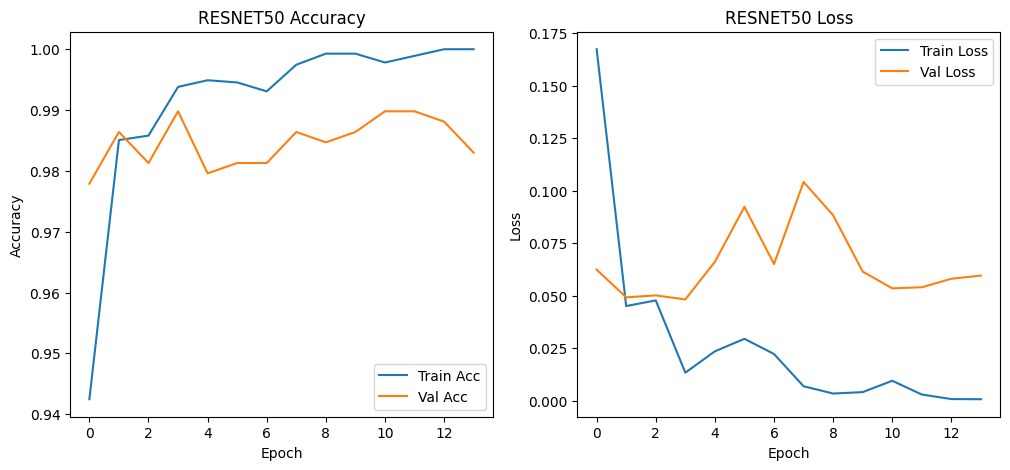


Classification Report:
              precision    recall  f1-score   support

       Hawar       0.98      0.96      0.97       179
       Karat       0.97      0.98      0.97       214
       Sehat       1.00      1.00      1.00       197

    accuracy                           0.98       590
   macro avg       0.98      0.98      0.98       590
weighted avg       0.98      0.98      0.98       590



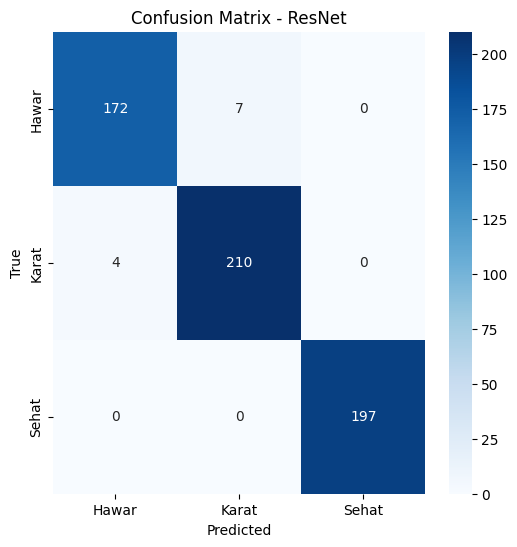


===== Training EFFICIENTNET_B0 =====


c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Train Loss: 0.1792 Train Acc: 0.9323 - Val Loss: 0.0489 Val Acc: 0.9796
Epoch 2/50 - Train Loss: 0.0466 Train Acc: 0.9847 - Val Loss: 0.0545 Val Acc: 0.9830
Epoch 3/50 - Train Loss: 0.0344 Train Acc: 0.9858 - Val Loss: 0.0335 Val Acc: 0.9864
Epoch 4/50 - Train Loss: 0.0341 Train Acc: 0.9880 - Val Loss: 0.0319 Val Acc: 0.9830
Epoch 5/50 - Train Loss: 0.0281 Train Acc: 0.9909 - Val Loss: 0.0643 Val Acc: 0.9779
Epoch 6/50 - Train Loss: 0.0520 Train Acc: 0.9851 - Val Loss: 0.0546 Val Acc: 0.9779
Epoch 7/50 - Train Loss: 0.0300 Train Acc: 0.9894 - Val Loss: 0.0683 Val Acc: 0.9847
Epoch 8/50 - Train Loss: 0.0207 Train Acc: 0.9927 - Val Loss: 0.0268 Val Acc: 0.9915
Epoch 9/50 - Train Loss: 0.0154 Train Acc: 0.9956 - Val Loss: 0.0378 Val Acc: 0.9898
Epoch 10/50 - Train Loss: 0.0058 Train Acc: 0.9982 - Val Loss: 0.0320 Val Acc: 0.9898
Epoch 11/50 - Train Loss: 0.0112 Train Acc: 0.9967 - Val Loss: 0.0914 Val Acc: 0.9847
Epoch 12/50 - Train Loss: 0.0116 Train Acc: 0.9964 - Val Loss: 

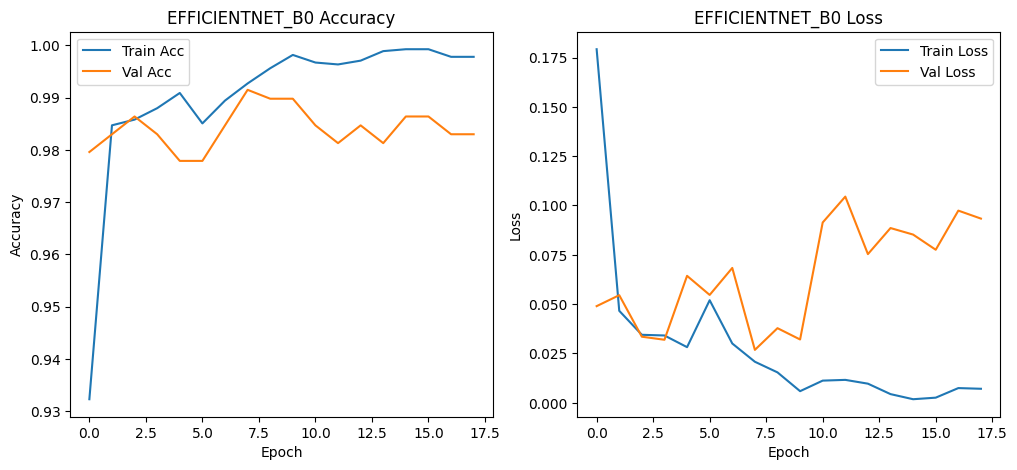


Classification Report:
              precision    recall  f1-score   support

       Hawar       0.94      0.98      0.96       179
       Karat       0.99      0.94      0.96       214
       Sehat       1.00      1.00      1.00       197

    accuracy                           0.97       590
   macro avg       0.97      0.98      0.97       590
weighted avg       0.98      0.97      0.97       590



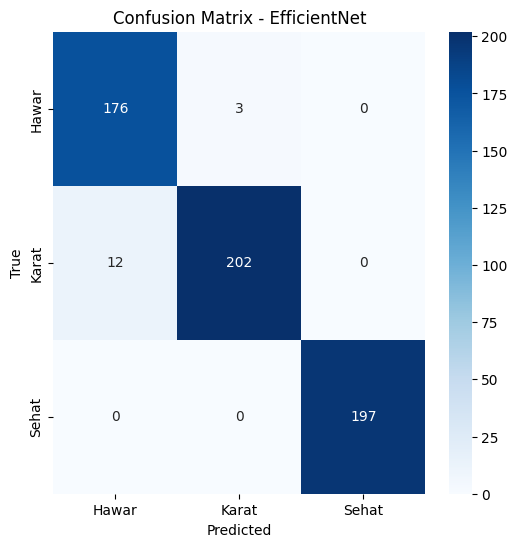

In [10]:
for arch in ["resnet50","efficientnet_b0"]:
    print(f"\n===== Training {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names), fine_tune=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=10)

    # Plot accuracy & loss curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f'{arch.upper()} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'{arch.upper()} Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, f"best_{type(model).__name__}.pth")

In [11]:
def visualize_gradcam(model, test_loader, target_layer, device, num_images=5):
    model.eval()
    images_shown = 0

    cam = GradCAM(model=model, target_layers=[target_layer])

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(images.size(0)):
            if images_shown >= num_images:
                return
            input_tensor = images[i].unsqueeze(0)
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            
            img_np = images[i].permute(1,2,0).cpu().numpy()
            img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            img_np = np.clip(img_np, 0, 1)

            cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
            
            plt.figure(figsize=(4,4))
            plt.imshow(cam_image)
            plt.title(f"True: {labels[i].item()}")
            plt.axis('off')
            plt.show()
            images_shown += 1


===== Grad-CAM for RESNET50 =====


c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


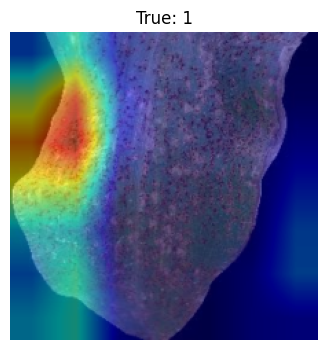

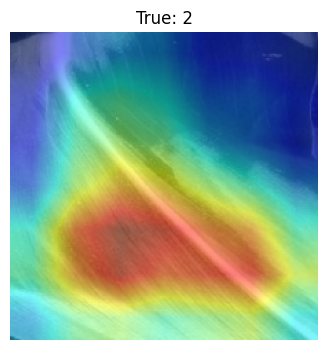

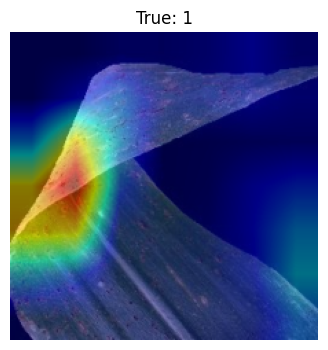

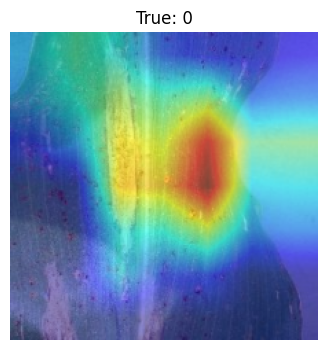

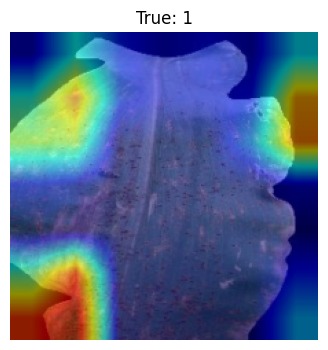


===== Grad-CAM for EFFICIENTNET_B0 =====


c:\Users\agnes julia\OneDrive\Desktop\sem 5\computer vision\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


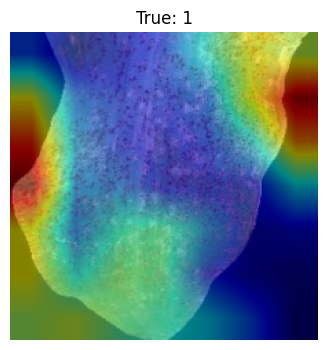

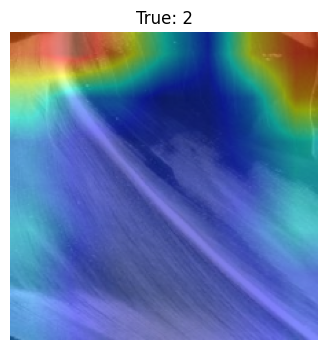

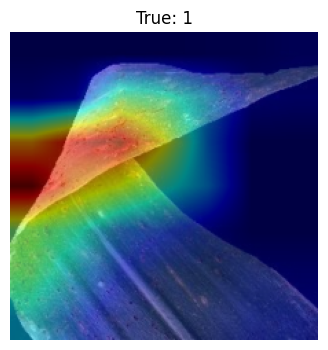

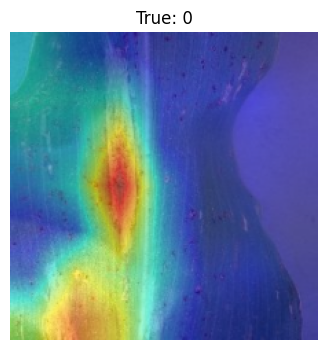

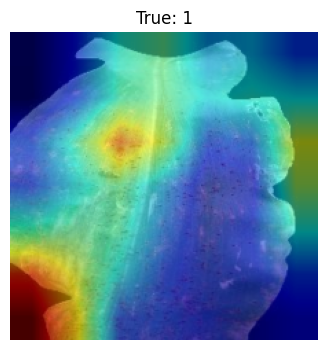

In [12]:
for arch in ["resnet50","efficientnet_b0"]:
    print(f"\n===== Grad-CAM for {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names), fine_tune=True)
    model.load_state_dict(torch.load(f"best_{type(model).__name__}.pth"))
    model.to(device)

    if arch == "resnet50":
        target_layer = model.layer4[-1].conv3
    else:  # "efficientnet_b0
        target_layer = model.features[-1]

    visualize_gradcam(model, test_loader, target_layer, device, num_images=5)